# Reinforcement Learning Project 1: Navigation

---

This projects implements a Reinforcement Learning Agent to Solve the Bananna Finding Problem, defined as the first chalenge of the [Udacity's Reinforcement Learning Nanodegree](udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

The model of the environment is built under Unity, and the Deep Learning Agent is written in Python, using PyTorch. 

## Installation

### Prerequisites

 - Python 3 and Pip
 - Install Anaconda or Miniconda 3 from [here](https://docs.conda.io/en/latest/miniconda.html)

### Installation
 - In the root folder folder, run `conda env create`. This will create a python environment to run the agent.
 - Activate the environment with `conda activate drlnd-navigation`.
 - Download and unzip the Unity environment executable in the folder from [here](https://classroom.udacity.com/nanodegrees/nd893/parts/6b0c03a7-6667-4fcf-a9ed-dd41a2f76485/modules/4eeb16ab-5ac5-47bf-974d-12784e9730d7/lessons/69bd42c6-b70e-4866-9764-9bfa8c03cdea/concepts/319dc918-bd2c-4d3b-80a5-063bb5f1905a)
   
   - For Linux (headless version, no visualization): 
   ```
   wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux_NoVis.zip & unzip Banana_Linux_NoVis.zip
   ```
   
   
   - For Linux (with visualization, [currently buggy](https://knowledge.udacity.com/questions/98593)): 
   ```
   wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip & unzip Banana_Linux.zip
   ```
## Usage

### Training
To train the agent from zero, run 
```
python train.py --env <path to environment> 
```
### Test
```
python test.py --env <path to environment> --checkpoint <path to checkpoint file>
```

# Problem Definition

A 3D environment where many blue and yellow bananas is defined. The environment is closed and its surface is squared shaped. 

An agent is spawned in a random location within this environment. The objective of the agent is to grab as many yellow bananas and as little blue bananas as possible. For each collected yellow banana, the agent is rewarded with +1 points, and for each blue, the agent is rewarded with -1 points. The agent collects a banana by moving to the banana's location. 

The agent can execute 4 different movements: move forward, backward, turn left, turn right. These 4 actions define the action space. The agent can see what lays in front of it. This view is defined by a camera view. The agent perceives the direction in which bananas within its field of view are located This information is encoded within the state's 27 element vector.

## Exploring the Environment

Let's load the environment and print some important variables and parameters of it. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment

# please do not modify the line below
env = UnityEnvironment(file_name="../deep-reinforcement-learning/p1_navigation/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))
action_size = brain.vector_action_space_size
print('Action Space length:', action_size)
state = env_info.vector_observations[0]
state_size = len(state)
print('State Space length:', state_size)

Number of agents: 1
Action Space length: 4
State Space length: 37


# Solution

### Agent
The agent is defined in `agent/agent.py`. The Agent uses a double deep Q network consisting of a target and a local network. Both networks are different instances of a deep Q network. The deep Q network defined here comprises an input 27th-dimensional layer (the state size), two 64 dimensions, fully convoluted hidden layers, and a 4-dimensional output layer (the action size). The network is shown in the diagram below. 

In [4]:
%load_ext itikz

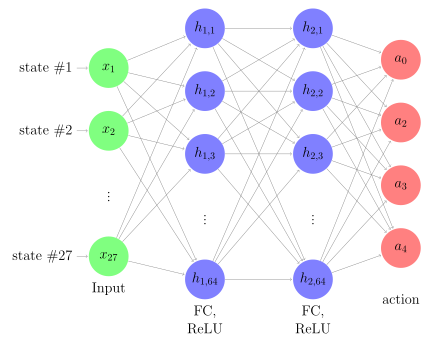

In [5]:
%%itikz
\documentclass[tikz, margin=3mm]{standalone}
\usetikzlibrary{calc, chains, positioning}

\begin{document}
\def\layersep{2.5cm}
\begin{tikzpicture}[shorten >=1pt,->, draw=black!50,
                    node distance = 8mm and 24mm,
                    start chain = going below,
                    every pin edge/.style = {<-,shorten <=1pt},
                    neuron/.style = {circle, fill=#1, 
                                     minimum size=40pt, inner sep=0pt},
                    annot/.style = {text width=4em, align=center},
                    font=\Large]

% Input layer
\foreach \i [count=\j] in {1,2,3,27}
{
    \ifnum\i=3
        \node[neuron=none, on chain]     (I-\j)  {$\vdots$};
    \else
        \node[neuron=green!50, on chain, pin=180:state \#\i]
            (I-\j)  {$x_{\i}$};
    \fi
}
\node[annot,below=of I-4.center]        {Input};
              
% Hidden Layer 1
\node[neuron=blue!50, above right= 4mm and 24mm of I-1](H-1) {$h_{1,1}$};
\foreach \i [count=\j from 1] in {2,3,4,64}
{
    \ifnum\i=4
        \node[neuron=none, below=of H-3] (H-4)  {$\vdots$};
    \else
        \node[neuron=blue!50, below=of H-\j]
            (H-\i)  {$h_{1,\i}$};
    \fi
}
\node[annot,below=of H-64.center]        {FC, ReLU};

% Hidenn Layer 2
\node[neuron=blue!50, right= 24mm of H-1](H2-1) {$h_{2,1}$};
\foreach \i [count=\j from 1] in {2,3,4,64}
{
    \ifnum\i=4
        \node[neuron=none, below=of H2-3] (H2-4)  {$\vdots$};
    \else
        \node[neuron=blue!50, below=of H2-\j]
            (H2-\i)  {$h_{2,\i}$};
    \fi
}
\node[annot,below=of H2-64.center]        {FC, ReLU};

              
% Output layer
\node[neuron=red!50,
        right=of $(H2-1)!0.5!(H2-2)$]  (O-1)   {$a_0$};
\foreach \i [count=\j from 1] in {2,3,4}
{
    \node[neuron=red!50, below=of O-\j] (O-\i) {$a_{\i}$};
}
\node[annot,below=of O-4] {action};

              
% Connect input nodes with hidden nodes and
%  hidden nodes with output nodes with the output layer
\foreach \i in {1,2,4}
    \foreach \j in {1,2,3,64}
    {
        \draw (I-\i) edge (H-\j);
    }
\foreach \i in {1,2,3,64}
    \foreach \j in {1,2,3,64}
    {
        \draw (H-\i) edge (H2-\j);
    }
\foreach \i in {1,2,3,64}
    \foreach \j in {1,2,3,4}
    {
        \draw (H2-\i) edge (O-\j);
    }

              
% \draw (O-1) -- node[below] {$h_{w,b}(x)$} + (2,0);
% Annotate layers

\end{tikzpicture}
\end{document}

Another parameters of the agent are:
 * Replay buffer size: 10000
 * Batch Size: 64
 * Discount Factor (gamma): 0.99
 * Soft update parameter (to describe how strong is the target network going to be updated to the local network on every update. 1 is total update, 0 is no update): 1e-3
 * Learning Rate of the Optimizer: 5e-4
 * Update target network to local network every: 4 iterations

In [6]:
from agent.agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### Trainer

We train the agent by using a trainer defined in `train.py`.  The trainer makes the agent train on the environment for a maximum of 2000 episodes. The epsilon greedy policy will vary from 
$ \epsilon_{0} = 1.0 $  linearly to $ \epsilon_{min} = 0.01 $ with a decay of $ \epsilon_{decay} = 0.995 $ .

In [7]:
%%time
from train import dqn_trainer
scores = dqn_trainer(agent, env, brain_name)

Episode 100	Average Score: 1.2	Current Score: 2.000
Episode 200	Average Score: 5.2	Current Score: 4.000
Episode 300	Average Score: 7.9	Current Score: 9.000
Episode 400	Average Score: 11.0	Current Score: 15.00
Episode 470	Average Score: 13.0	Current Score: 16.00
Environment solved in 370 episodes!	Average Score: 13.0
Saving results in checkpoint2020-04-20.pth
CPU times: user 3min 29s, sys: 16.6 s, total: 3min 46s
Wall time: 5min 11s


I have achieved an average of 13 points in less than 500 epochs! The final number of epochs displayed is substracted by 100, just like it was calculated on the [official DQN exercise solution](https://github.com/udacity/deep-reinforcement-learning/blob/dc65050c8f47b365560a30a112fb84f762005c6b/dqn/solution/Deep_Q_Network_Solution.ipynb#L173). However, this number is still far below the mark of 1800 epochs set to improve.

The evolution of the scores along epochs is seen below.

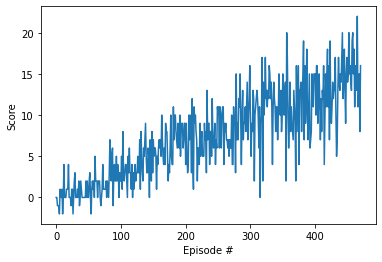

In [8]:
import matplotlib.pyplot as plt

import numpy as np 

plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test

We test the behaviour of the trained agent on the same environment by using `test.py`.

In [9]:
from test import dqn_tester

In [10]:
dqn_tester(agent, env, brain_name)

Finishing score: 18.0.


18.0

In [11]:
env.close()

# Possible Improvements

* We can implement dueling DQN and other optimization techniques mentioned in the lectures. 
* We can fiddle and optimize the hyper parameters for faster learning. 
* We can include a video demo of how the trained agent performs on the environment.
* Based on the above, the video demo can be also displayed as an animated GIF to be showcased in the repo website.